## RandAugmentation_simple
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [1]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

if "./" not in sys.path:
    sys.path.append("./")

In [2]:
from src.model import Model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion

In [3]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

DATASET_DIR = "./input/cifar10"

In [4]:
def generate_transform(resize: int = 32, aug_fcns: Tuple = ()) -> transforms.transforms.Compose:
    """Generate train augmentation policy."""
    transform_fcns = []
    transform_fcns.append(transforms.Resize((resize, resize)))
    transform_fcns += list(aug_fcns)
    
    transform_fcns.append(transforms.ToTensor())
    transform_fcns.append(transforms.Normalize(MEAN_V, STD_V))
    
    return transforms.Compose(transform_fcns)
    

In [5]:
def load_cifar10(img_size: int = 32, 
                 aug_fcns: Tuple = (), 
                 validation_ratio: float = 0.8,
                ) -> Tuple[CIFAR10, CIFAR10, CIFAR10]:
    tf_train = generate_transform(resize=img_size, aug_fcns=aug_fcns)
    tf_test = generate_transform(resize=img_size)
    
    train_dataset = CIFAR10(root=DATASET_DIR, train=True, download=True, transform=tf_train)
    train_length = int(len(train_dataset) * validation_ratio)
    val_length = len(train_dataset) - train_length

    train_dataset, val_dataset = random_split(train_dataset, [train_length, val_length])
    test_dataset = CIFAR10(root=DATASET_DIR, train=False, download=True, transform=tf_test)
    
    return train_dataset, val_dataset, test_dataset
    

In [6]:
def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset: CIFAR10, _val_dataset: CIFAR10, _test_dataset: CIFAR10, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(_val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

In [7]:
import optuna
import yaml

In [8]:
EPOCHS = 10
BATCH_SIZE = 256
    
def objective(trial: optuna.Trial) -> float:
    img_size = 32

    augmentation_functions = []
    use_color_jitter = trial.suggest_categorical("aug_color_jitter", [True, False])
    use_random_perspective = trial.suggest_categorical("aug_random_perspective", [True, False])
    use_random_flip = trial.suggest_categorical("aug_random_flip", [True, False])
    
    if use_color_jitter:
        augmentation_functions.append(transforms.ColorJitter(brightness=(0.5, 1.5), 
                                                             contrast=(0.5, 1.5), 
                                                             saturation=(0.5, 1.5)))
    if use_random_perspective:
        augmentation_functions.append(transforms.RandomPerspective())
    
    if use_random_flip:
        augmentation_functions.append(transforms.RandomHorizontalFlip())
    
        
    train_dataset, val_dataset, test_dataset = load_cifar10(img_size=img_size, 
                                                            aug_fcns = tuple(augmentation_functions), 
                                                            validation_ratio=0.8)
    
    visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix=f"Trial {trial.number:03d} //")
    plt.draw()
    plt.show()
    print(augmentation_functions)
    
    with open("./configs/model/mobilenetv3.yaml", "r") as f:
        model_cfg = yaml.load(f, yaml.SafeLoader)

    model_cfg['backbone'][-1][-1] = [10]

    model = Model(model_cfg, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
    criterion = CustomCriterion(samples_per_cls=None, device=device)

    train_loader = DataLoader(dataset=train_dataset, 
                              pin_memory=torch.cuda.is_available(), 
                              shuffle=True, 
                              batch_size=BATCH_SIZE, 
                              num_workers=4, 
                              drop_last=True)
    val_loader = DataLoader(dataset=val_dataset, 
                            pin_memory=torch.cuda.is_available(), 
                            shuffle=False, 
                            batch_size=BATCH_SIZE, 
                            num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, 
                             pin_memory=torch.cuda.is_available(), 
                             shuffle=False, 
                             batch_size=BATCH_SIZE, 
                             num_workers=4)

    exp_dir = "./exp/autoaug"
    os.makedirs(exp_dir, exist_ok=True)
    trainer = TorchTrainer(model=model, 
                           criterion=criterion, 
                           optimizer=optimizer, 
                           scheduler=scheduler, 
                           device=device, 
                           verbose=1, 
                           model_path=os.path.join(exp_dir, "best.pt"))

    best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                      n_epoch=EPOCHS, 
                                      val_dataloader=val_loader)
    print("TEST DATASET")
    test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)
    
    return test_f1

[I 2021-11-23 11:33:06,499] A new study created in memory with name: autoaug


0it [00:00, ?it/s]

Extracting ./input/cifar10/cifar-10-python.tar.gz to ./input/cifar10
Files already downloaded and verified


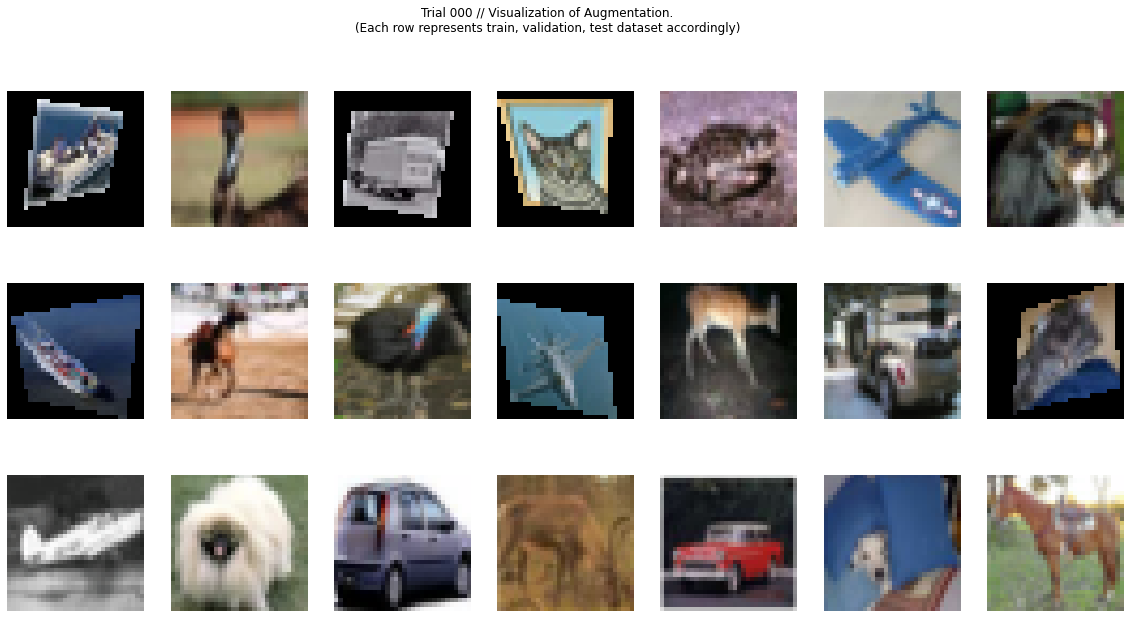

[RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |   

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jujoo (use `wandb login --relogin` to force relogin)


Train: [001] Loss: 2.029, Acc: 24.55% F1(macro): 0.24: 100%|██████████| 156/156 [00:10<00:00, 14.62it/s]
 Val:       Loss: 1.790, Acc: 34.54% F1(macro): 0.33: 100%|██████████| 40/40 [00:01<00:00, 34.92it/s]


Model saved. Current best test f1: 0.325


Train: [002] Loss: 1.677, Acc: 37.94% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.59it/s]
 Val:       Loss: 1.605, Acc: 40.40% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 36.72it/s]


Model saved. Current best test f1: 0.392


Train: [003] Loss: 1.542, Acc: 42.91% F1(macro): 0.42: 100%|██████████| 156/156 [00:10<00:00, 14.71it/s]
 Val:       Loss: 1.509, Acc: 44.43% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 36.25it/s]


Model saved. Current best test f1: 0.438


Train: [004] Loss: 1.458, Acc: 46.56% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.56it/s]
 Val:       Loss: 1.444, Acc: 47.70% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 33.74it/s]


Model saved. Current best test f1: 0.471


Train: [005] Loss: 1.399, Acc: 48.95% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 14.86it/s]
 Val:       Loss: 1.404, Acc: 49.27% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 35.65it/s]


Model saved. Current best test f1: 0.492


Train: [006] Loss: 1.347, Acc: 51.10% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.64it/s]
 Val:       Loss: 1.344, Acc: 51.17% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 35.19it/s]


Model saved. Current best test f1: 0.509


Train: [007] Loss: 1.301, Acc: 52.89% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 15.01it/s]
 Val:       Loss: 1.310, Acc: 52.64% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 34.96it/s]


Model saved. Current best test f1: 0.523


Train: [008] Loss: 1.254, Acc: 54.74% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 15.11it/s]
 Val:       Loss: 1.272, Acc: 53.89% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 36.34it/s]


Model saved. Current best test f1: 0.535


Train: [009] Loss: 1.218, Acc: 56.16% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.71it/s]
 Val:       Loss: 1.263, Acc: 55.03% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 35.97it/s]


Model saved. Current best test f1: 0.545


Train: [010] Loss: 1.189, Acc: 57.28% F1(macro): 0.57: 100%|██████████| 156/156 [00:10<00:00, 14.96it/s]
 Val:       Loss: 1.224, Acc: 56.44% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 35.57it/s]


Model saved. Current best test f1: 0.560
TEST DATASET


 Val:       Loss: 1.114, Acc: 59.73% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 38.37it/s]
[I 2021-11-23 11:35:42,640] Trial 0 finished with value: 0.5942552759447878 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 0 with value: 0.5942552759447878.


Files already downloaded and verified
Files already downloaded and verified


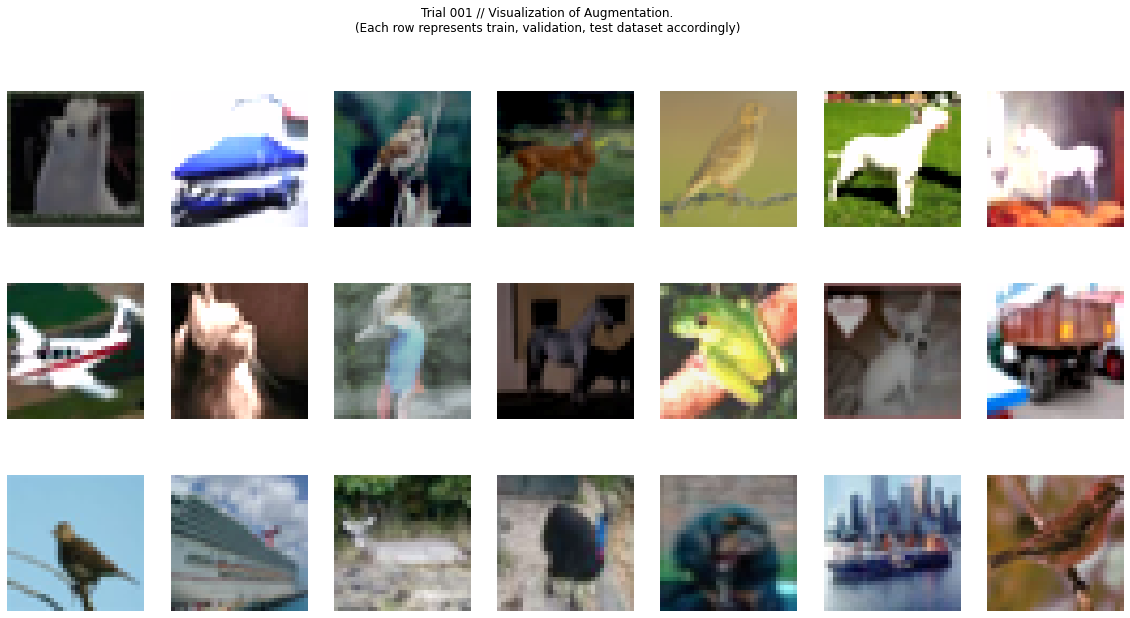

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     

test/acc,▁▃▄▅▆▆▇▇██
test/f1,▁▃▄▅▆▆▇▇██
train/acc,▁▄▅▆▆▇▇▇██
train/f1,▁▄▅▆▆▇▇▇██
train/loss,█▅▄▃▃▂▂▂▁▁
test/acc,0.5644
test/f1,0.56001
train/acc,57.27664
train/f1,0.57078
train/loss,1.18936


Train: [001] Loss: 2.094, Acc: 22.28% F1(macro): 0.22: 100%|██████████| 156/156 [00:10<00:00, 14.54it/s]
 Val:       Loss: 1.926, Acc: 30.47% F1(macro): 0.28: 100%|██████████| 40/40 [00:02<00:00, 17.27it/s]


Model saved. Current best test f1: 0.283


Train: [002] Loss: 1.713, Acc: 36.93% F1(macro): 0.36: 100%|██████████| 156/156 [00:11<00:00, 13.84it/s]
 Val:       Loss: 1.647, Acc: 39.60% F1(macro): 0.38: 100%|██████████| 40/40 [00:02<00:00, 19.48it/s]


Model saved. Current best test f1: 0.379


Train: [003] Loss: 1.558, Acc: 43.16% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.57it/s]
 Val:       Loss: 1.524, Acc: 44.57% F1(macro): 0.43: 100%|██████████| 40/40 [00:01<00:00, 20.17it/s]


Model saved. Current best test f1: 0.428


Train: [004] Loss: 1.457, Acc: 47.01% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 14.51it/s]
 Val:       Loss: 1.429, Acc: 47.91% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 20.01it/s]


Model saved. Current best test f1: 0.477


Train: [005] Loss: 1.377, Acc: 50.20% F1(macro): 0.50: 100%|██████████| 156/156 [00:11<00:00, 13.70it/s]
 Val:       Loss: 1.374, Acc: 50.64% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 20.55it/s]


Model saved. Current best test f1: 0.502


Train: [006] Loss: 1.309, Acc: 52.73% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.58it/s]
 Val:       Loss: 1.335, Acc: 51.22% F1(macro): 0.52: 100%|██████████| 40/40 [00:02<00:00, 19.85it/s]


Model saved. Current best test f1: 0.515


Train: [007] Loss: 1.235, Acc: 55.86% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.66it/s]
 Val:       Loss: 1.269, Acc: 54.99% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 20.10it/s]


Model saved. Current best test f1: 0.549


Train: [008] Loss: 1.183, Acc: 57.83% F1(macro): 0.58: 100%|██████████| 156/156 [00:10<00:00, 14.53it/s]
 Val:       Loss: 1.219, Acc: 57.12% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 20.15it/s]


Model saved. Current best test f1: 0.564


Train: [009] Loss: 1.123, Acc: 59.82% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.58it/s]
 Val:       Loss: 1.180, Acc: 58.23% F1(macro): 0.58: 100%|██████████| 40/40 [00:02<00:00, 19.32it/s]


Model saved. Current best test f1: 0.578


Train: [010] Loss: 1.073, Acc: 61.95% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 14.42it/s]
 Val:       Loss: 1.164, Acc: 59.03% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 20.30it/s]


Model saved. Current best test f1: 0.589
TEST DATASET


 Val:       Loss: 1.096, Acc: 60.16% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 38.72it/s]
[I 2021-11-23 11:38:14,821] Trial 1 finished with value: 0.598637412542488 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 1 with value: 0.598637412542488.


Files already downloaded and verified
Files already downloaded and verified


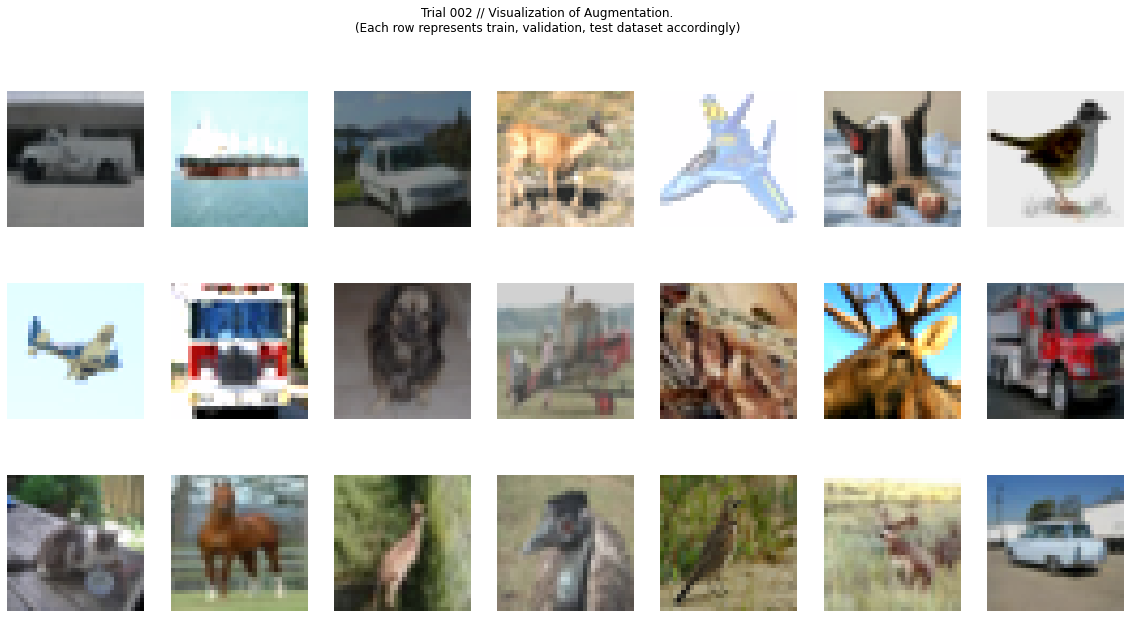

[ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |

test/acc,▁▃▄▅▆▆▇███
test/f1,▁▃▄▅▆▆▇▇██
train/acc,▁▄▅▅▆▆▇▇██
train/f1,▁▄▅▅▆▆▇▇██
train/loss,█▅▄▄▃▃▂▂▁▁
test/acc,0.5903
test/f1,0.58939
train/acc,61.94661
train/f1,0.61804
train/loss,1.07347


Train: [001] Loss: 2.048, Acc: 23.25% F1(macro): 0.23: 100%|██████████| 156/156 [00:10<00:00, 14.69it/s]
 Val:       Loss: 1.957, Acc: 31.61% F1(macro): 0.29: 100%|██████████| 40/40 [00:02<00:00, 17.79it/s]


Model saved. Current best test f1: 0.286


Train: [002] Loss: 1.693, Acc: 37.62% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.33it/s]
 Val:       Loss: 1.643, Acc: 40.22% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 21.27it/s]


Model saved. Current best test f1: 0.390


Train: [003] Loss: 1.536, Acc: 43.71% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.54it/s]
 Val:       Loss: 1.532, Acc: 44.03% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 21.25it/s]


Model saved. Current best test f1: 0.437


Train: [004] Loss: 1.434, Acc: 48.08% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.49it/s]
 Val:       Loss: 1.426, Acc: 48.91% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 21.46it/s]


Model saved. Current best test f1: 0.482


Train: [005] Loss: 1.343, Acc: 51.65% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.52it/s]
 Val:       Loss: 1.357, Acc: 51.24% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 21.89it/s]


Model saved. Current best test f1: 0.508


Train: [006] Loss: 1.256, Acc: 54.66% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.71it/s]
 Val:       Loss: 1.302, Acc: 53.55% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 21.21it/s]


Model saved. Current best test f1: 0.528


Train: [007] Loss: 1.193, Acc: 57.43% F1(macro): 0.57: 100%|██████████| 156/156 [00:10<00:00, 14.43it/s]
 Val:       Loss: 1.283, Acc: 53.97% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 21.13it/s]


Model saved. Current best test f1: 0.534


Train: [008] Loss: 1.113, Acc: 60.29% F1(macro): 0.60: 100%|██████████| 156/156 [00:10<00:00, 14.38it/s]
 Val:       Loss: 1.193, Acc: 57.29% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 21.40it/s]


Model saved. Current best test f1: 0.571


Train: [009] Loss: 1.047, Acc: 62.87% F1(macro): 0.63: 100%|██████████| 156/156 [00:10<00:00, 14.51it/s]
 Val:       Loss: 1.170, Acc: 59.13% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 20.80it/s]


Model saved. Current best test f1: 0.588


Train: [010] Loss: 1.002, Acc: 64.49% F1(macro): 0.64: 100%|██████████| 156/156 [00:10<00:00, 14.36it/s]
 Val:       Loss: 1.140, Acc: 60.19% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 21.47it/s]


Model saved. Current best test f1: 0.600
TEST DATASET


 Val:       Loss: 1.093, Acc: 61.39% F1(macro): 0.61: 100%|██████████| 40/40 [00:01<00:00, 36.99it/s]
[I 2021-11-23 11:40:44,977] Trial 2 finished with value: 0.6104110770759871 and parameters: {'aug_color_jitter': True, 'aug_random_perspective': False, 'aug_random_flip': False}. Best is trial 2 with value: 0.6104110770759871.


Files already downloaded and verified
Files already downloaded and verified


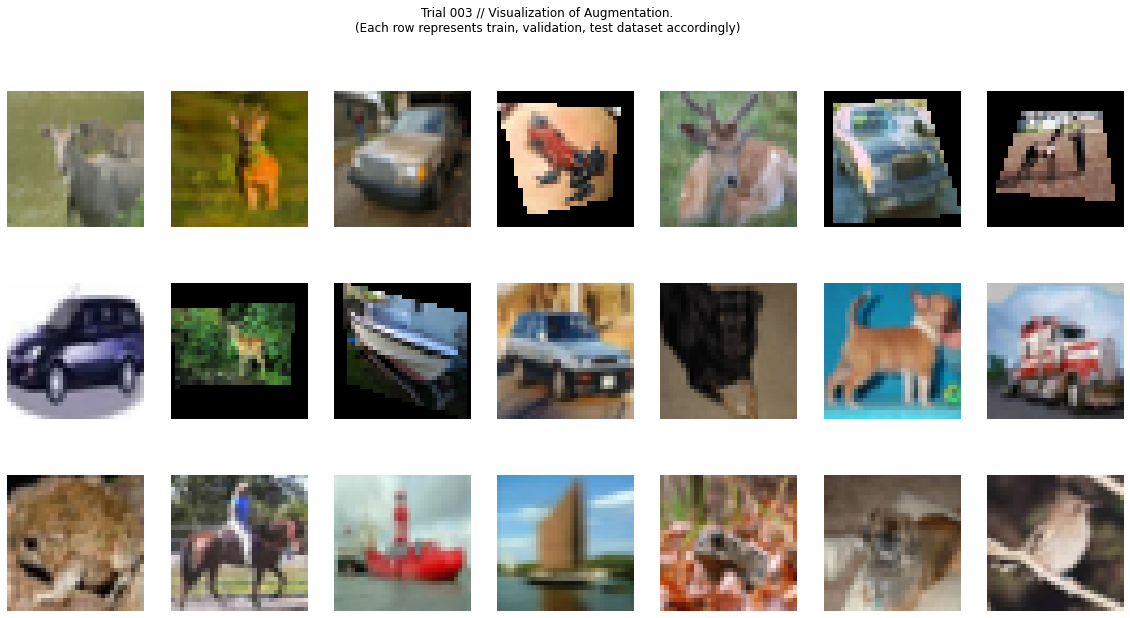

[RandomPerspective(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |   

test/acc,▁▃▄▅▆▆▆▇██
test/f1,▁▃▄▅▆▆▇▇██
train/acc,▁▃▄▅▆▆▇▇██
train/f1,▁▃▄▅▆▆▇▇██
train/loss,█▆▅▄▃▃▂▂▁▁
test/acc,0.6019
test/f1,0.5996
train/acc,64.48818
train/f1,0.64332
train/loss,1.002


Train: [001] Loss: 2.035, Acc: 24.53% F1(macro): 0.24: 100%|██████████| 156/156 [00:10<00:00, 14.66it/s]
 Val:       Loss: 1.817, Acc: 32.75% F1(macro): 0.31: 100%|██████████| 40/40 [00:01<00:00, 36.21it/s]


Model saved. Current best test f1: 0.312


Train: [002] Loss: 1.673, Acc: 38.21% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.87it/s]
 Val:       Loss: 1.620, Acc: 40.85% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 35.12it/s]


Model saved. Current best test f1: 0.389


Train: [003] Loss: 1.538, Acc: 43.97% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 15.06it/s]
 Val:       Loss: 1.496, Acc: 45.04% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 34.98it/s]


Model saved. Current best test f1: 0.443


Train: [004] Loss: 1.444, Acc: 47.54% F1(macro): 0.47: 100%|██████████| 156/156 [00:10<00:00, 14.80it/s]
 Val:       Loss: 1.449, Acc: 46.51% F1(macro): 0.46: 100%|██████████| 40/40 [00:01<00:00, 35.59it/s]


Model saved. Current best test f1: 0.460


Train: [005] Loss: 1.386, Acc: 49.58% F1(macro): 0.49: 100%|██████████| 156/156 [00:10<00:00, 14.82it/s]
 Val:       Loss: 1.397, Acc: 48.56% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 35.00it/s]


Model saved. Current best test f1: 0.485


Train: [006] Loss: 1.338, Acc: 51.51% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.60it/s]
 Val:       Loss: 1.388, Acc: 50.23% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 35.44it/s]


Model saved. Current best test f1: 0.494


Train: [007] Loss: 1.293, Acc: 53.37% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 14.90it/s]
 Val:       Loss: 1.331, Acc: 51.34% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 35.28it/s]


Model saved. Current best test f1: 0.509


Train: [008] Loss: 1.245, Acc: 55.13% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.74it/s]
 Val:       Loss: 1.262, Acc: 54.31% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 35.10it/s]


Model saved. Current best test f1: 0.543


Train: [009] Loss: 1.204, Acc: 56.62% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.89it/s]
 Val:       Loss: 1.282, Acc: 54.11% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 36.05it/s]
Train: [010] Loss: 1.185, Acc: 57.43% F1(macro): 0.57: 100%|██████████| 156/156 [00:10<00:00, 14.64it/s]
 Val:       Loss: 1.274, Acc: 54.23% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 35.09it/s]


TEST DATASET


 Val:       Loss: 1.170, Acc: 58.52% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 38.58it/s]
[I 2021-11-23 11:43:04,413] Trial 3 finished with value: 0.5808189911443499 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': False}. Best is trial 2 with value: 0.6104110770759871.


Files already downloaded and verified
Files already downloaded and verified


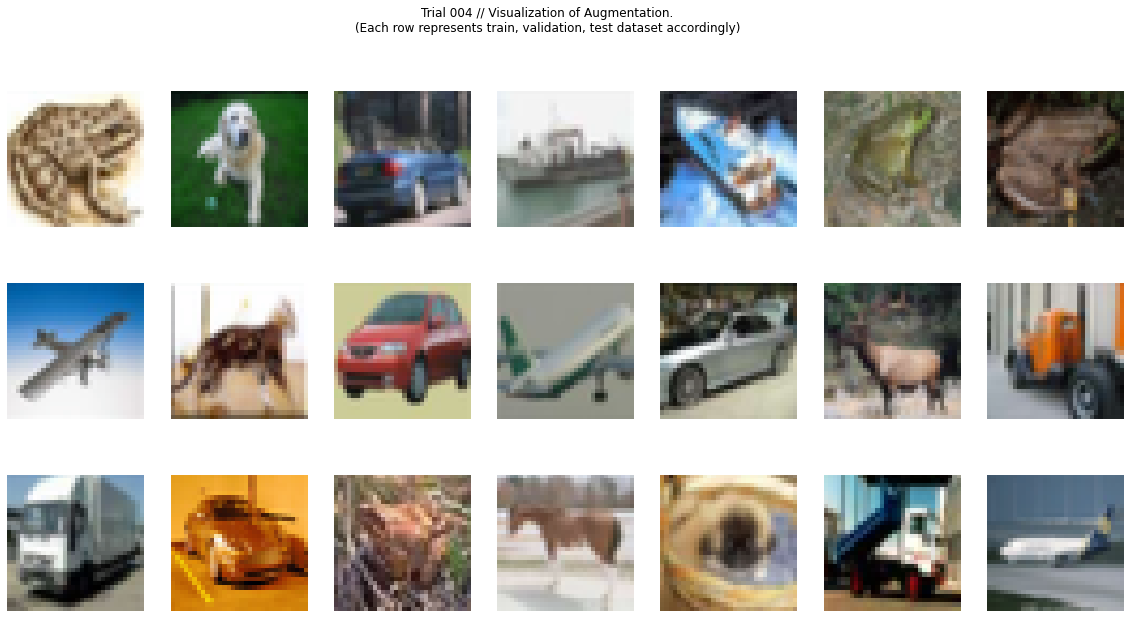

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

test/acc,▁▄▅▅▆▇▇███
test/f1,▁▃▅▅▆▇▇███
train/acc,▁▄▅▆▆▇▇███
train/f1,▁▄▅▆▆▇▇███
train/loss,█▅▄▃▃▂▂▁▁▁
test/acc,0.5423
test/f1,0.5358
train/acc,57.4344
train/f1,0.57224
train/loss,1.18507


Train: [001] Loss: 1.925, Acc: 28.37% F1(macro): 0.28: 100%|██████████| 156/156 [00:10<00:00, 14.86it/s]
 Val:       Loss: 1.642, Acc: 40.34% F1(macro): 0.40: 100%|██████████| 40/40 [00:01<00:00, 36.41it/s]


Model saved. Current best test f1: 0.398


Train: [002] Loss: 1.524, Acc: 44.33% F1(macro): 0.44: 100%|██████████| 156/156 [00:10<00:00, 14.83it/s]
 Val:       Loss: 1.442, Acc: 47.38% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 37.78it/s]


Model saved. Current best test f1: 0.468


Train: [003] Loss: 1.368, Acc: 50.26% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 14.71it/s]
 Val:       Loss: 1.364, Acc: 50.81% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 37.71it/s]


Model saved. Current best test f1: 0.497


Train: [004] Loss: 1.283, Acc: 53.48% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 14.82it/s]
 Val:       Loss: 1.282, Acc: 53.11% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 39.92it/s]


Model saved. Current best test f1: 0.524


Train: [005] Loss: 1.208, Acc: 56.44% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.86it/s]
 Val:       Loss: 1.248, Acc: 55.64% F1(macro): 0.55: 100%|██████████| 40/40 [00:01<00:00, 38.31it/s]


Model saved. Current best test f1: 0.550


Train: [006] Loss: 1.144, Acc: 59.10% F1(macro): 0.59: 100%|██████████| 156/156 [00:10<00:00, 14.90it/s]
 Val:       Loss: 1.214, Acc: 57.28% F1(macro): 0.57: 100%|██████████| 40/40 [00:01<00:00, 35.98it/s]


Model saved. Current best test f1: 0.568


Train: [007] Loss: 1.078, Acc: 61.69% F1(macro): 0.62: 100%|██████████| 156/156 [00:10<00:00, 14.92it/s]
 Val:       Loss: 1.156, Acc: 58.55% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 39.15it/s]


Model saved. Current best test f1: 0.586


Train: [008] Loss: 1.016, Acc: 63.88% F1(macro): 0.64: 100%|██████████| 156/156 [00:10<00:00, 15.17it/s]
 Val:       Loss: 1.127, Acc: 59.98% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 39.64it/s]


Model saved. Current best test f1: 0.600


Train: [009] Loss: 0.974, Acc: 65.35% F1(macro): 0.65: 100%|██████████| 156/156 [00:10<00:00, 14.80it/s]
 Val:       Loss: 1.071, Acc: 62.51% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 38.85it/s]


Model saved. Current best test f1: 0.621


Train: [010] Loss: 0.936, Acc: 66.88% F1(macro): 0.67: 100%|██████████| 156/156 [00:10<00:00, 15.06it/s]
 Val:       Loss: 1.068, Acc: 63.19% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 37.89it/s]


Model saved. Current best test f1: 0.629
TEST DATASET


 Val:       Loss: 1.060, Acc: 62.54% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 39.92it/s]
[I 2021-11-23 11:45:24,211] Trial 4 finished with value: 0.6241775021243562 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 4 with value: 0.6241775021243562.


Files already downloaded and verified
Files already downloaded and verified


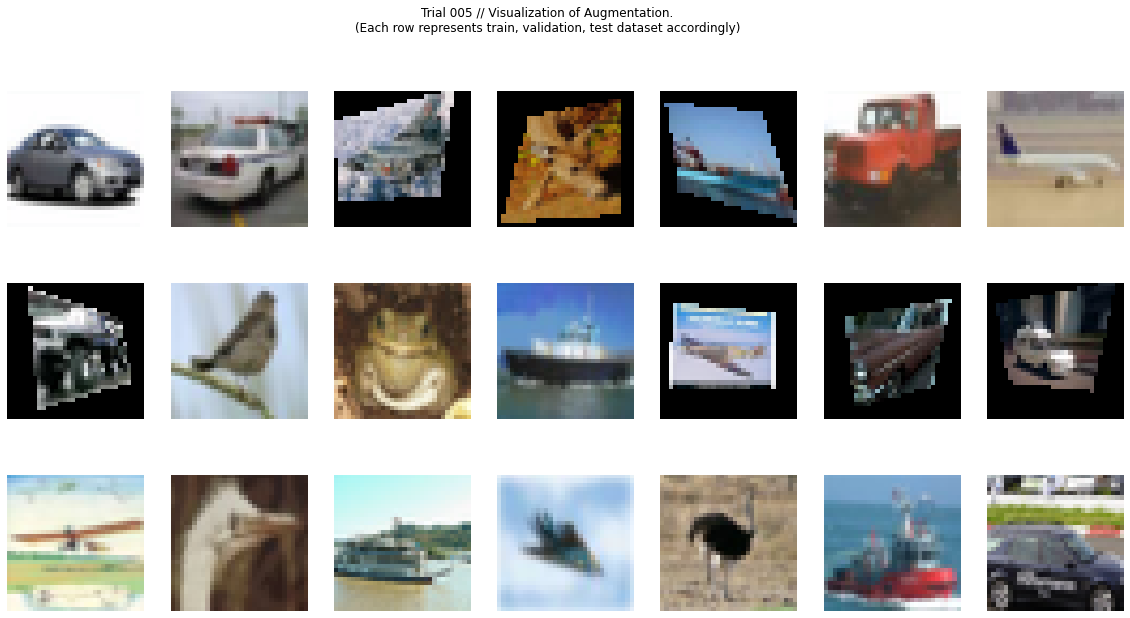

[RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           4

test/acc,▁▃▄▅▆▆▇▇██
test/f1,▁▃▄▅▆▆▇▇██
train/acc,▁▄▅▆▆▇▇▇██
train/f1,▁▄▅▆▆▇▇▇██
train/loss,█▅▄▃▃▂▂▂▁▁
test/acc,0.6319
test/f1,0.62926
train/acc,66.88452
train/f1,0.66855
train/loss,0.93585


Train: [001] Loss: 2.022, Acc: 24.60% F1(macro): 0.24: 100%|██████████| 156/156 [00:10<00:00, 14.75it/s]
 Val:       Loss: 1.825, Acc: 31.90% F1(macro): 0.30: 100%|██████████| 40/40 [00:01<00:00, 32.86it/s]


Model saved. Current best test f1: 0.296


Train: [002] Loss: 1.685, Acc: 37.39% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.58it/s]
 Val:       Loss: 1.612, Acc: 41.05% F1(macro): 0.40: 100%|██████████| 40/40 [00:01<00:00, 31.25it/s]


Model saved. Current best test f1: 0.398


Train: [003] Loss: 1.548, Acc: 43.12% F1(macro): 0.43: 100%|██████████| 156/156 [00:10<00:00, 14.25it/s]
 Val:       Loss: 1.531, Acc: 44.11% F1(macro): 0.42: 100%|██████████| 40/40 [00:01<00:00, 33.05it/s]


Model saved. Current best test f1: 0.425


Train: [004] Loss: 1.471, Acc: 46.14% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.49it/s]
 Val:       Loss: 1.493, Acc: 47.02% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 33.15it/s]


Model saved. Current best test f1: 0.470


Train: [005] Loss: 1.418, Acc: 48.07% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.58it/s]
 Val:       Loss: 1.419, Acc: 48.32% F1(macro): 0.47: 100%|██████████| 40/40 [00:01<00:00, 31.57it/s]


Model saved. Current best test f1: 0.471


Train: [006] Loss: 1.365, Acc: 50.68% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 14.83it/s]
 Val:       Loss: 1.369, Acc: 50.66% F1(macro): 0.50: 100%|██████████| 40/40 [00:01<00:00, 31.43it/s]


Model saved. Current best test f1: 0.500


Train: [007] Loss: 1.324, Acc: 52.30% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.81it/s]
 Val:       Loss: 1.360, Acc: 50.94% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 31.58it/s]


Model saved. Current best test f1: 0.509


Train: [008] Loss: 1.276, Acc: 54.00% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.76it/s]
 Val:       Loss: 1.272, Acc: 54.68% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 33.31it/s]


Model saved. Current best test f1: 0.541


Train: [009] Loss: 1.251, Acc: 55.14% F1(macro): 0.55: 100%|██████████| 156/156 [00:10<00:00, 14.47it/s]
 Val:       Loss: 1.237, Acc: 55.55% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 32.41it/s]


Model saved. Current best test f1: 0.556


Train: [010] Loss: 1.211, Acc: 56.82% F1(macro): 0.57: 100%|██████████| 156/156 [00:10<00:00, 14.65it/s]
 Val:       Loss: 1.221, Acc: 56.60% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 31.53it/s]


Model saved. Current best test f1: 0.563
TEST DATASET


 Val:       Loss: 1.107, Acc: 60.70% F1(macro): 0.61: 100%|██████████| 40/40 [00:00<00:00, 41.04it/s]
[I 2021-11-23 11:47:46,980] Trial 5 finished with value: 0.6058808824046987 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': True}. Best is trial 4 with value: 0.6241775021243562.


Files already downloaded and verified
Files already downloaded and verified


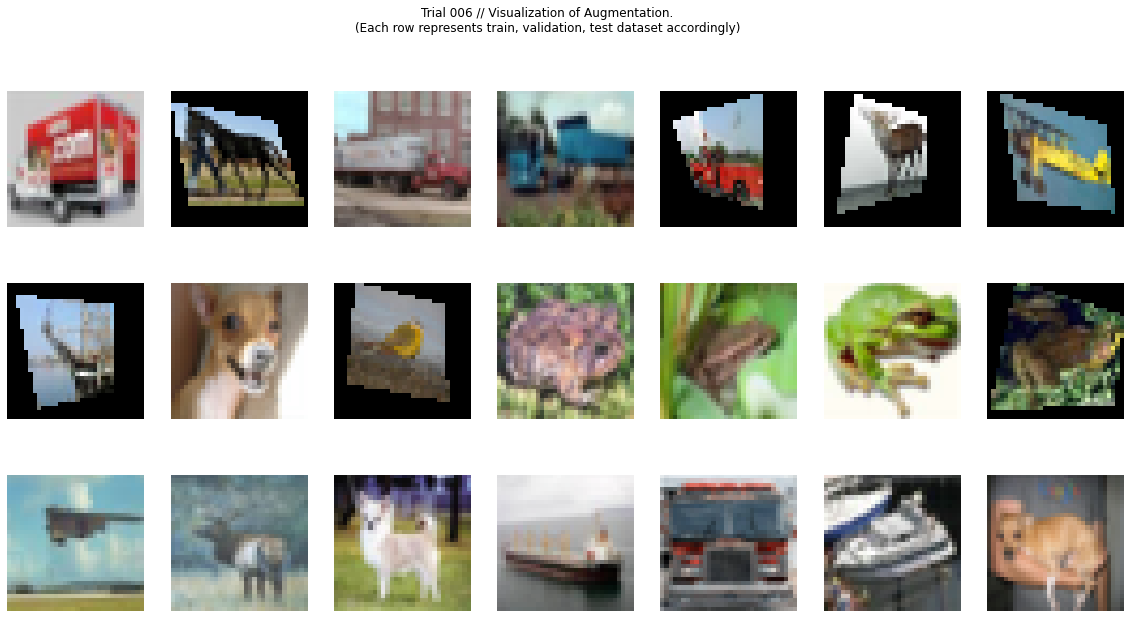

[RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           4

test/acc,▁▄▄▅▆▆▆▇██
test/f1,▁▄▄▆▆▆▇▇██
train/acc,▁▄▅▆▆▇▇▇██
train/f1,▁▄▅▆▆▇▇▇██
train/loss,█▅▄▃▃▂▂▂▁▁
test/acc,0.566
test/f1,0.56314
train/acc,56.82342
train/f1,0.56622
train/loss,1.2107


Train: [001] Loss: 2.054, Acc: 23.77% F1(macro): 0.23: 100%|██████████| 156/156 [00:10<00:00, 14.44it/s]
 Val:       Loss: 1.875, Acc: 31.72% F1(macro): 0.30: 100%|██████████| 40/40 [00:01<00:00, 32.57it/s]


Model saved. Current best test f1: 0.295


Train: [002] Loss: 1.703, Acc: 37.29% F1(macro): 0.37: 100%|██████████| 156/156 [00:10<00:00, 14.49it/s]
 Val:       Loss: 1.622, Acc: 40.56% F1(macro): 0.39: 100%|██████████| 40/40 [00:01<00:00, 32.56it/s]


Model saved. Current best test f1: 0.391


Train: [003] Loss: 1.566, Acc: 42.49% F1(macro): 0.42: 100%|██████████| 156/156 [00:10<00:00, 14.69it/s]
 Val:       Loss: 1.520, Acc: 44.65% F1(macro): 0.44: 100%|██████████| 40/40 [00:01<00:00, 30.47it/s]


Model saved. Current best test f1: 0.438


Train: [004] Loss: 1.481, Acc: 46.31% F1(macro): 0.46: 100%|██████████| 156/156 [00:10<00:00, 14.34it/s]
 Val:       Loss: 1.469, Acc: 46.30% F1(macro): 0.46: 100%|██████████| 40/40 [00:01<00:00, 32.62it/s]


Model saved. Current best test f1: 0.458


Train: [005] Loss: 1.416, Acc: 48.74% F1(macro): 0.48: 100%|██████████| 156/156 [00:10<00:00, 14.62it/s]
 Val:       Loss: 1.423, Acc: 49.11% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 32.96it/s]


Model saved. Current best test f1: 0.486


Train: [006] Loss: 1.374, Acc: 50.22% F1(macro): 0.50: 100%|██████████| 156/156 [00:10<00:00, 14.80it/s]
 Val:       Loss: 1.384, Acc: 49.29% F1(macro): 0.49: 100%|██████████| 40/40 [00:01<00:00, 32.72it/s]


Model saved. Current best test f1: 0.488


Train: [007] Loss: 1.329, Acc: 52.08% F1(macro): 0.52: 100%|██████████| 156/156 [00:10<00:00, 14.67it/s]
 Val:       Loss: 1.348, Acc: 51.81% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 31.45it/s]


Model saved. Current best test f1: 0.508


Train: [008] Loss: 1.285, Acc: 53.62% F1(macro): 0.53: 100%|██████████| 156/156 [00:10<00:00, 14.69it/s]
 Val:       Loss: 1.342, Acc: 52.46% F1(macro): 0.52: 100%|██████████| 40/40 [00:01<00:00, 31.55it/s]


Model saved. Current best test f1: 0.517


Train: [009] Loss: 1.258, Acc: 54.74% F1(macro): 0.54: 100%|██████████| 156/156 [00:10<00:00, 14.67it/s]
 Val:       Loss: 1.312, Acc: 53.29% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 33.44it/s]


Model saved. Current best test f1: 0.528


Train: [010] Loss: 1.224, Acc: 55.94% F1(macro): 0.56: 100%|██████████| 156/156 [00:10<00:00, 14.39it/s]
 Val:       Loss: 1.284, Acc: 55.19% F1(macro): 0.54: 100%|██████████| 40/40 [00:01<00:00, 31.28it/s]


Model saved. Current best test f1: 0.543
TEST DATASET


 Val:       Loss: 1.150, Acc: 58.87% F1(macro): 0.58: 100%|██████████| 40/40 [00:01<00:00, 38.48it/s]
[I 2021-11-23 11:50:10,381] Trial 6 finished with value: 0.5789968356212342 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': True, 'aug_random_flip': True}. Best is trial 4 with value: 0.6241775021243562.


Files already downloaded and verified
Files already downloaded and verified


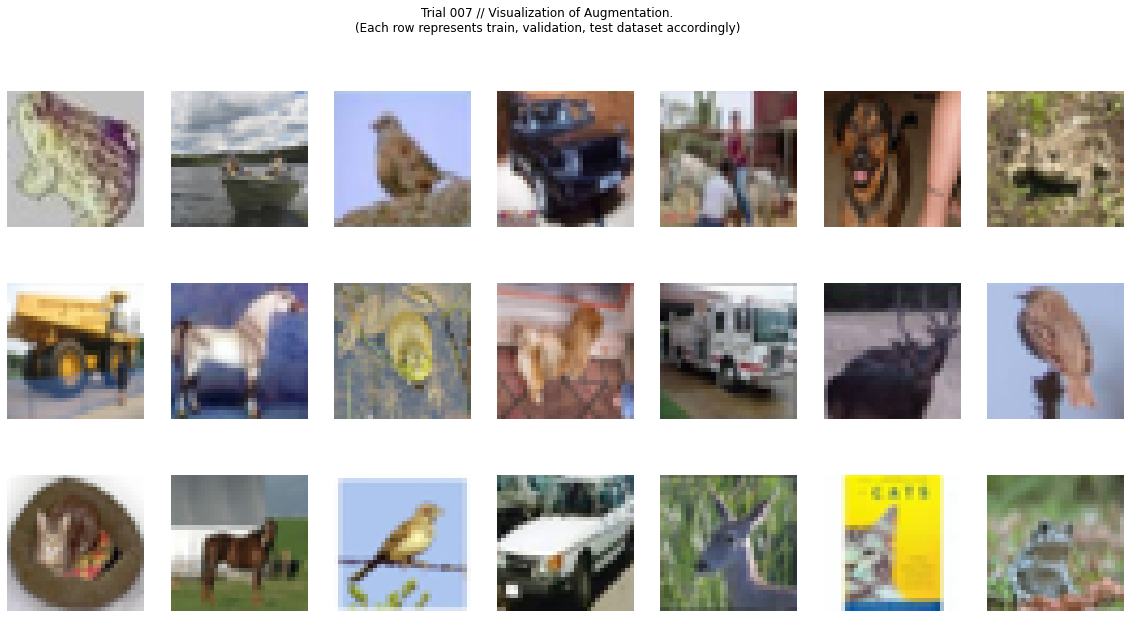

[RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           40           80
  8 |   1 |

test/acc,▁▄▅▅▆▆▇▇▇█
test/f1,▁▄▅▆▆▆▇▇██
train/acc,▁▄▅▆▆▇▇▇██
train/f1,▁▄▅▆▆▇▇▇██
train/loss,█▅▄▃▃▂▂▂▁▁
test/acc,0.5519
test/f1,0.54295
train/acc,55.94451
train/f1,0.55693
train/loss,1.22413


Train: [001] Loss: 1.913, Acc: 28.30% F1(macro): 0.28: 100%|██████████| 156/156 [00:10<00:00, 14.71it/s]
 Val:       Loss: 1.609, Acc: 39.87% F1(macro): 0.38: 100%|██████████| 40/40 [00:01<00:00, 35.69it/s]


Model saved. Current best test f1: 0.382


Train: [002] Loss: 1.492, Acc: 45.54% F1(macro): 0.45: 100%|██████████| 156/156 [00:10<00:00, 14.60it/s]
 Val:       Loss: 1.428, Acc: 48.31% F1(macro): 0.48: 100%|██████████| 40/40 [00:01<00:00, 39.15it/s]


Model saved. Current best test f1: 0.482


Train: [003] Loss: 1.354, Acc: 50.85% F1(macro): 0.51: 100%|██████████| 156/156 [00:10<00:00, 14.66it/s]
 Val:       Loss: 1.320, Acc: 52.00% F1(macro): 0.51: 100%|██████████| 40/40 [00:01<00:00, 37.14it/s]


Model saved. Current best test f1: 0.511


Train: [004] Loss: 1.249, Acc: 55.39% F1(macro): 0.55: 100%|██████████| 156/156 [00:11<00:00, 14.06it/s]
 Val:       Loss: 1.263, Acc: 53.86% F1(macro): 0.53: 100%|██████████| 40/40 [00:01<00:00, 37.67it/s]


Model saved. Current best test f1: 0.534


Train: [005] Loss: 1.167, Acc: 58.35% F1(macro): 0.58: 100%|██████████| 156/156 [00:10<00:00, 14.59it/s]
 Val:       Loss: 1.201, Acc: 56.90% F1(macro): 0.56: 100%|██████████| 40/40 [00:01<00:00, 39.62it/s]


Model saved. Current best test f1: 0.556


Train: [006] Loss: 1.095, Acc: 60.73% F1(macro): 0.61: 100%|██████████| 156/156 [00:10<00:00, 14.61it/s]
 Val:       Loss: 1.151, Acc: 58.99% F1(macro): 0.59: 100%|██████████| 40/40 [00:01<00:00, 37.64it/s]


Model saved. Current best test f1: 0.590


Train: [007] Loss: 1.041, Acc: 63.13% F1(macro): 0.63: 100%|██████████| 156/156 [00:10<00:00, 14.53it/s]
 Val:       Loss: 1.107, Acc: 60.10% F1(macro): 0.60: 100%|██████████| 40/40 [00:01<00:00, 38.97it/s]


Model saved. Current best test f1: 0.596


Train: [008] Loss: 0.986, Acc: 64.90% F1(macro): 0.65: 100%|██████████| 156/156 [00:10<00:00, 14.60it/s]
 Val:       Loss: 1.066, Acc: 62.21% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 37.45it/s]


Model saved. Current best test f1: 0.618


Train: [009] Loss: 0.951, Acc: 66.17% F1(macro): 0.66: 100%|██████████| 156/156 [00:10<00:00, 14.66it/s]
 Val:       Loss: 1.075, Acc: 62.37% F1(macro): 0.62: 100%|██████████| 40/40 [00:01<00:00, 36.83it/s]


Model saved. Current best test f1: 0.618


Train: [010] Loss: 0.916, Acc: 67.57% F1(macro): 0.67: 100%|██████████| 156/156 [00:10<00:00, 15.04it/s]
 Val:       Loss: 1.048, Acc: 62.98% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 39.79it/s]


Model saved. Current best test f1: 0.629
TEST DATASET


 Val:       Loss: 1.059, Acc: 63.03% F1(macro): 0.63: 100%|██████████| 40/40 [00:01<00:00, 38.68it/s]
[I 2021-11-23 11:52:32,356] Trial 7 finished with value: 0.6290144525758872 and parameters: {'aug_color_jitter': False, 'aug_random_perspective': False, 'aug_random_flip': True}. Best is trial 7 with value: 0.6290144525758872.


Files already downloaded and verified
Files already downloaded and verified


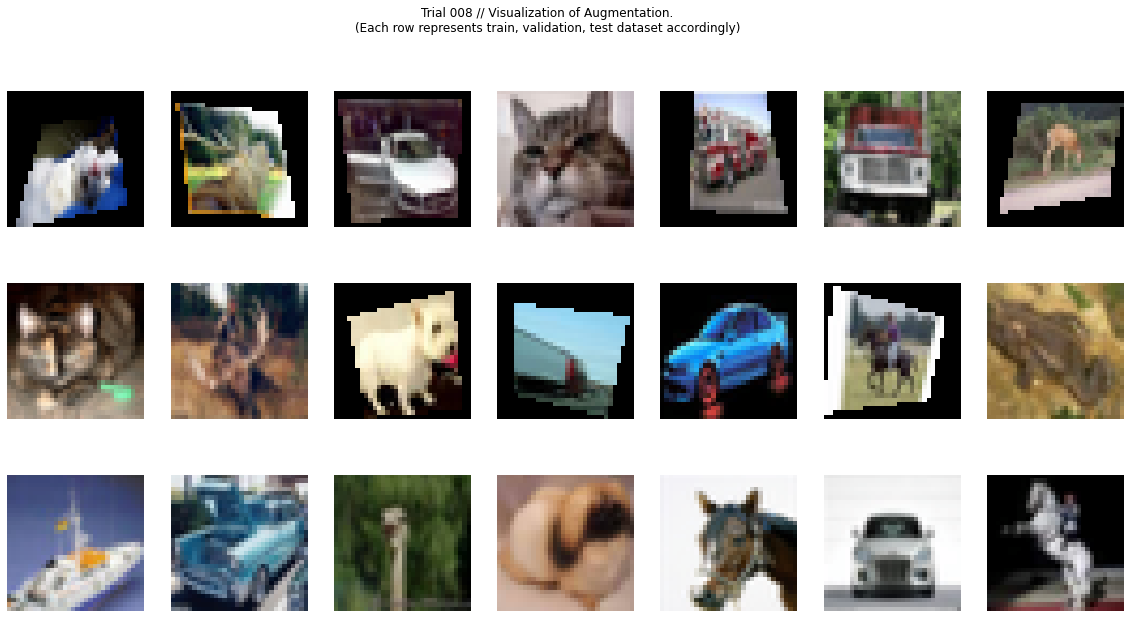

[RandomPerspective(p=0.5), RandomHorizontalFlip(p=0.5)]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  7 |   1 |     32,080 | InvertedResidualv3 |  [3, 6, 80, 0, 1, 2] |           4

test/acc,▁▄▅▅▆▇▇███
test/f1,▁▄▅▅▆▇▇███
train/acc,▁▄▅▆▆▇▇███
train/f1,▁▄▅▆▆▇▇███
train/loss,█▅▄▃▃▂▂▁▁▁
test/acc,0.6298
test/f1,0.6288
train/acc,67.5656
train/f1,0.67472
train/loss,0.91634


In [9]:
study = optuna.create_study(direction="maximize", study_name="autoaug", load_if_exists=True)
study.optimize(objective, n_trials=100)